In [1]:
#Syncing the python with snappy installation
import sys
sys.path.append(r'C:\Users\s1111191\.snap\snap-python')

In [2]:
#Major lib imports
import esa_snappy
from esa_snappy import ProductIO
from esa_snappy import HashMap
import os, gc
from esa_snappy import GPF
from esa_snappy import jpy

FOLLOWING THE PIPELINE FOR SAR SLC PREPROCESSING

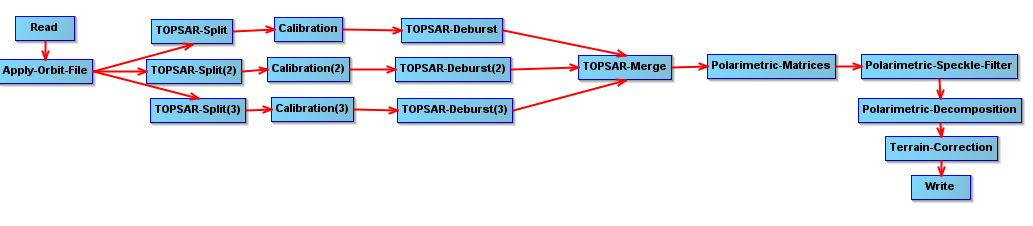

In [3]:
# Hashmap is used to give us access to all JAVA oerators
HashMap = jpy.get_type('java.util.HashMap')
parameters = HashMap()

In [4]:
#Applying Orbital file

def apply_orbit_file(p):
    print('Applying orbit file..')
    GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()
    parameters.put('Apply-Orbit-File', True)
    parameters.put('orbitType','Sentinel Precise (Auto Download)')
    parameters.put('continueOnFail','false')
    output = GPF.createProduct('Apply-Orbit-File', parameters, p)
    return output

In [ ]:
#Creating a subset of the Product
def subset(p,wkt=r'C:\SNAP\B_EXPORT.CSV'):
    print('Creating Subset..')
    parameters.put('geoRegion',wkt)
    output = GPF.createProduct('Subset',parameters,p)
    return output

In [6]:
#Spliting the SLC image into seperate IW: IW1, IW2, IW3 (Loop through each swath widths)

def topsar_split(p,slice='IW1'):
    print('Spliting..')
    parameters.put('subswath', slice)
    parameters.put('selectedPolarisations', 'VH,VV')
    output=GPF.createProduct("TOPSAR-Split", parameters, p)
    return output

In [7]:
#Calibration of the IW
def calibration(p):
    print('Calibrating..')
    parameters.put('outputImageInComplex',True)
    parameters.put('selectedPolarisations', 'VH,VV')
    output = GPF.createProduct('Calibration', parameters, p)
    return output

In [8]:
#Debursting the IW
def topsar_deburst(p):  
    print('Debursting..')
    parameters.put('selectedPolarisations', 'VH,VV')
    output=GPF.createProduct("TOPSAR-Deburst", parameters, p)
    return output

In [20]:
#Merging Splited IW into one
def topsar_merge(p1,p2,p3):
    print('Merging IW..')
    parameters.put('selectedPolarisations', 'VH,VV')
    output=GPF.createProduct("TOPSAR-Merge", parameters, p1,p2,p3)
    return output

In [21]:
def split_cal_deb_merge(p):
    for slc in ['IW1', 'IW2', 'IW3']:
        if slc =='IW1':
            p1=topsar_split(p,slc)
            p1=calibration(p1)
            p1=topsar_deburst(p1)
        elif slc == 'IW2':
            p2=topsar_split(p,slc)
            p2=calibration(p2)
            p2=topsar_deburst(p2)
        else:
            p3=topsar_split(p,slc)
            p3=calibration(p3)
            p3=topsar_deburst(p3)
        
    output = topsar_merge(p1,p2,p3)
    return output

In [11]:
#Creating the C2 Matrix
def polarimetric_matrices(p):
     print('Creating Matrix..')
     parameters.put('matrix','C2')
     output=GPF.createProduct('Polarimetric-Matrices', parameters, p)
     return output

In [12]:
#Creating Speckle filter
def Speckle_filter(p):
    print('Speckle Filtering..')
    parameters.put('filter', 'Refined Lee Filter')
    parameters.put('numLooksStr', '1')
    parameters.put('windowSize', '7x7')
    output=GPF.createProduct("Polarimetric-Speckle-Filter", parameters, p)
    return output

In [13]:
#Correcing the Geometry
def Terrain_Correction(p):
    print('Correcting the terrain..')
    parameters.put('mapProjection','WGS84(DD)')
    output=GPF.createProduct("Terrain-Correction", parameters, p)
    return output

In [14]:
#Decomposing the layer
def polarimetric_decomposition(p):
    print('Decomposing..')
    parameters.put('decomposition','H-Alpha Dual Pol Decomposition')
    parameters.put('windowSize','5')
    output=GPF.createProduct("Polarimetric-Decomposition", parameters, p)
    return output

In [15]:
#Writing the final product in BEAM-DIMAP format
def write(product, filename):
    print('Product writing..')
    ProductIO.writeProduct(product, filename, "BEAM-DIMAP")

In [22]:
def execute():

    #Importing the product as p (We can use .zip or .dim files here)
    p = ProductIO.readProduct(r'C:\SNAP\S1A_IW_SLC__1SDV_20210722T005513_20210722T005539_038883_049695_5707.zip')

    #Importing the functions
    a = apply_orbit_file(p)
    b = split_cal_deb_merge(a)
    c = polarimetric_matrices(b)
    #d = Speckle_filter(c)
    e = Terrain_Correction(c)
    f = polarimetric_decomposition(e)

    write(f,r'C:\SNAP\system_main')
    return None

In [ ]:
#Executing the main function
if __name__ == "__main__":
    execute()

Applying orbit file..
Spliting..
Calibrating..
Debursting..
Spliting..
Calibrating..
Debursting..
Spliting..
Calibrating..
Debursting..
Merging IW..
Creating Matrix..
Correcting the terrain..
Decomposing..
Product writing..
